In [527]:
import torch.nn as nn
import torch
from torch.autograd import Variable
import os
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
import numpy as np
import pandas as pd
from PIL import Image
import time

In [541]:
def image_loader(path)->list:
    if os.path.exists(path):
        print('dirs exits')
    else:
        print('0')
    r = []
    for root,dirs,files_ in os.walk(path):
        print(root,len(files_))
        for file in files_:
            img = Image.open(root+'/'+file)
            img = img.convert('L')
            #将图片缩小到指定大小
            # 图像归一化
            transform_GY = transforms.ToTensor()#将PIL.Image转化为tensor，即归一化。
            # 注：shape 会从(H，W，C)变成(C，H，W)
            
            # 图像标准化
            transform_BZ=  transforms.Normalize((0.1307,),(0.1307,))
            transform_RS = transforms.Resize((80,80), interpolation=2)
            transform_compose= transforms.Compose([
            # 先缩放,再归一化再标准化
                transform_RS,
                transform_GY,
                transform_BZ
            ])

            img_result = transform_compose(img)
            r.append(img_result.numpy())

    return r, files_

In [529]:
im_list_neg,_ = image_loader(r'D:\GitHub\rich diseases\imageCrop\rice_leaf_diseases\0')
im_list_pos,_ = image_loader(r'D:\GitHub\rich diseases\imageCrop\rice_leaf_diseases\1')

dirs exits
D:\GitHub\rich diseases\imageCrop\rice_leaf_diseases\0 100
dirs exits
D:\GitHub\rich diseases\imageCrop\rice_leaf_diseases\1 100


In [530]:
import random
def randowmDate(dates,labels):
    temp = list(zip(dates,labels))
    random.shuffle(temp)
    res_dates,res_labels=zip(*temp)
    
    return np.array(res_dates),np.array(res_labels)

In [531]:
def dataToTensor(im_np_neg:np.ndarray, im_np_pos:np.ndarray, needTest:str):
    #将图像的三阶矩阵降为二阶矩阵
    im_np_neg = im_np_neg.reshape(100,80*80)
    im_np_pos = im_np_pos.reshape(100,80*80)
    #生成图片的分类标签
    im_np_neg_labels = np.zeros((1,len(im_np_neg)))
    im_np_pos_labels = np.ones((1,len(im_np_pos)))
    #将正负两个标签的二维矩阵合并成一个矩阵
    images = np.append(im_np_pos,im_np_neg,axis=0)
    labels = np.append(im_np_pos_labels,im_np_neg_labels, axis=1).flatten()
    #随机打乱样本
    index = [i for i in range(images.shape[0])]
    np.random.shuffle(index)
    images = images[index]
    labels = labels[index]
    images = torch.tensor(images)
    labels = torch.LongTensor(labels)
    if needTest == 't':
        #划分训练集和测试集
        test_rate = 0.3
        bound = int(len(images)*(1-test_rate))
        images_trains = images[:bound,]
        labels_trains = labels[:bound,]
        images_tests = images[bound+1:,]
        labels_tests = labels[bound+1:,]
        
        return images_trains,labels_trains,images_tests,labels_tests
    return images, labels

In [567]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(80*80,80*80),
            nn.ReLU(),
            nn.Linear(80*80, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(1024,2)
        )
    def forward(self, x):
        x = self.layer(x)
        return x

In [568]:
images_trains, labels_trains, images_tests, labels_tests = dataToTensor(np.array(im_list_neg), np.array(im_list_pos),'t')
# images, labels = dataToTensor(np.array(im_list_neg), np.array(im_list_pos),'f')
# images.shape

In [570]:
model = Model()

In [571]:
cost = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 100

-------Train begin--------
epoch:1, Train Accuracy is:50.7143%
epoch:2, Train Accuracy is:51.4286%
epoch:3, Train Accuracy is:51.4286%
epoch:4, Train Accuracy is:51.4286%
epoch:5, Train Accuracy is:51.4286%
epoch:6, Train Accuracy is:52.1429%
epoch:7, Train Accuracy is:52.1429%
epoch:8, Train Accuracy is:62.8571%
epoch:9, Train Accuracy is:52.8571%
epoch:10, Train Accuracy is:57.1429%
epoch:11, Train Accuracy is:58.5714%
epoch:12, Train Accuracy is:67.8571%
epoch:13, Train Accuracy is:60.7143%
epoch:14, Train Accuracy is:63.5714%
epoch:15, Train Accuracy is:62.8571%
epoch:16, Train Accuracy is:70.0000%
epoch:17, Train Accuracy is:54.2857%
epoch:18, Train Accuracy is:79.2857%
epoch:19, Train Accuracy is:68.5714%
epoch:20, Train Accuracy is:68.5714%
epoch:21, Train Accuracy is:81.4286%
epoch:22, Train Accuracy is:80.7143%
epoch:23, Train Accuracy is:89.2857%
epoch:24, Train Accuracy is:85.0000%
epoch:25, Train Accuracy is:90.0000%
epoch:26, Train Accuracy is:80.7143%
epoch:27, Train Accu

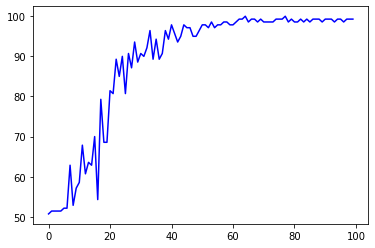

In [572]:
t = time.time()
print('-------Train begin--------')

running_loss_s = []
running_corrects = []
for epoch in range(n_epochs):
    running_correct=0
    
    images,labels = Variable(images_trains),Variable(labels_trains)
    outputs = model(images)
    _,pred_labels = torch.max(outputs, 1)
    optimizer.zero_grad()
    loss = cost(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss_s.append(loss.data.item())
    running_correct += torch.sum(pred_labels == labels.data)
    running_corrects.append(100*running_correct.item()/len(images))

    print("epoch:{}, Train Accuracy is:{:.4f}%".\
        format(epoch+1,100*running_correct.item()/len(images)))
t_ = time.time() - t
print('-----Train Use time: {:.0f}m {:.0f}s'.format(t_ // 60, t_ % 60))
plt.plot([i for i in range(n_epochs)],running_corrects,'b-')

In [573]:
t = time.time()
print('-------Test begin--------')
test_corrects = []
for epoch in range(10):
    test_correct = 0

    images, labels = Variable(images_tests),Variable(labels_tests)
    outputs = model(images)
    _,pred_labels = torch.max(outputs,1)
    test_correct += torch.sum(pred_labels == labels)
    test_corrects.append(100*test_correct.item()/len(images))
    print("epoch:{}, Test Accuracy is:{:.2f}%".\
          format(epoch+1,100*test_correct.item()/len(images)))
t_ = time.time() - t
print('-----Test Use time: {:.0f}m {:.0f}s'.format(t_ // 60, t_ % 60))

print('Average Test Accuracy : {:.2f}%'.format(np.average(test_corrects)))
# plt.plot([i for i in range(10)], test_corrects,'r-')

-------Test begin--------
epoch:1, Test Accuracy is:98.31%
epoch:2, Test Accuracy is:94.92%
epoch:3, Test Accuracy is:98.31%
epoch:4, Test Accuracy is:96.61%
epoch:5, Test Accuracy is:98.31%
epoch:6, Test Accuracy is:98.31%
epoch:7, Test Accuracy is:96.61%
epoch:8, Test Accuracy is:98.31%
epoch:9, Test Accuracy is:98.31%
epoch:10, Test Accuracy is:98.31%
-----Test Use time: 0m 1s
Average Test Accuracy : 97.63%


In [544]:
def detaction(path)->bool:
    #path 为图像目录的路径

    #注意：这里的files_只是图片名的集合，后续处理，需要处理成绝对路径
    images_list,files_ = image_loader(path)
    images = np.array(images_list).reshape(-1,80*80)
    images = torch.tensor(images)
    img_ = Variable(images)
    outputs = model(img_)
    _,pred_y = torch.max(outputs, 1)
    print(path+'\\'+files_[10])
    def test_and_show():
        index = 11
        print(pred_y[index])
        t_img = Image.open(path+'\\'+files_[index])
        plt.imshow(t_img)
    test_and_show()
    pred_y_list = pred_y.numpy().tolist()
    for i,pred_value in enumerate(pred_y_list):
        if pred_value == 0:
            os.remove(path+'\\'+files_[i])
            print('remove : '+path+'\\'+files_[i])

ses\imageCrop\rice_leaf_diseases\Leaf smut\DSC_0509.jpg\image-23.jpg
remove : D:\GitHub\rich diseases\imageCrop\rice_leaf_diseases\Leaf smut\DSC_0509.jpg\image-24.jpg
remove : D:\GitHub\rich diseases\imageCrop\rice_leaf_diseases\Leaf smut\DSC_0509.jpg\image-25.jpg
remove : D:\GitHub\rich diseases\imageCrop\rice_leaf_diseases\Leaf smut\DSC_0509.jpg\image-26.jpg
remove : D:\GitHub\rich diseases\imageCrop\rice_leaf_diseases\Leaf smut\DSC_0509.jpg\image-27.jpg
remove : D:\GitHub\rich diseases\imageCrop\rice_leaf_diseases\Leaf smut\DSC_0509.jpg\image-28.jpg
remove : D:\GitHub\rich diseases\imageCrop\rice_leaf_diseases\Leaf smut\DSC_0509.jpg\image-29.jpg
remove : D:\GitHub\rich diseases\imageCrop\rice_leaf_diseases\Leaf smut\DSC_0509.jpg\image-30.jpg
remove : D:\GitHub\rich diseases\imageCrop\rice_leaf_diseases\Leaf smut\DSC_0509.jpg\image-32.jpg
remove : D:\GitHub\rich diseases\imageCrop\rice_leaf_diseases\Leaf smut\DSC_0509.jpg\image-33.jpg
remove : D:\GitHub\rich diseases\imageCrop\rice_l

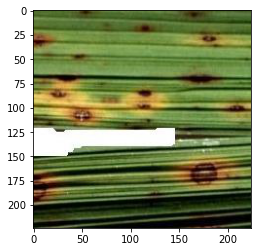

In [559]:

# detaction(r'D:\GitHub\rich diseases\imageCrop\rice_leaf_diseases\Bacterial leaf blight\DSC_0367.JPG')

root_paths=(r'D:\GitHub\rich diseases\imageCrop\rice_leaf_diseases\Bacterial leaf blight',r'D:\GitHub\rich diseases\imageCrop\rice_leaf_diseases\Brown spot',
r'D:\GitHub\rich diseases\imageCrop\rice_leaf_diseases\Leaf smut')
# for path_ in root_paths:
#     for root,dirs,fileNames in os.walk(path):
#             print(root)
for path in root_paths:
    for dir_ in os.listdir(path):
        detaction(path+'\\'+dir_)

    